In [1]:
import sys
print(sys.version)
%matplotlib inline
%run -i ~/Python/pjr3

3.10.1 | packaged by conda-forge | (main, Dec 22 2021, 01:39:05) [GCC 9.4.0]
pjr3.py complete


In [2]:
import os
#host = os.environ.get('HOST')
#print(host)
#print(os.environ)
import platform
host = platform.node()
print(host)

indir = os.path.expanduser('~/NetCDF_Files/F2010_PJR1.eam.h0.0001-01.nc')
print(indir)
#print('exists',os.path.exists(indir))
DS = xr.open_mfdataset(indir).chunk({'time': 20})
#print(DS)
weights = DS.area
weights.name = 'weights'
print(weights)
print('weights.sum',weights.sum().values,4.*pi)
#Var = DS.FSNT.isel(time=0)


xubuntuvm4
/home/phil/NetCDF_Files/F2010_PJR1.eam.h0.0001-01.nc
<xarray.DataArray 'weights' (ncol: 21600)>
dask.array<open_dataset-a75c3e8c97e2ec2f1adf030c713a00b9area, shape=(21600,), dtype=float64, chunksize=(21600,), chunktype=numpy.ndarray>
Dimensions without coordinates: ncol
Attributes:
    long_name:  physics grid areas
weights.sum 12.566370614359244 12.566370614359172


In [3]:
import regionmask

regionmask.__version__

'0.9.0'

plotfile regions.pdf


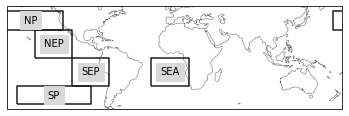

In [4]:
regList = []
nameList = []
abbrevList = []

name, abbrev, reg = "North_Pacific", "NP", np.array([[160.,30.],[-130.%360,30.],[-130.%360,50.],[160.,50.]])
name, abbrev, reg = "North_Pacific", "NP", np.array([[170.,30.],[-120.%360,30.],[-120.%360,50.],[170.,50.]])
regList, nameList, abbrevList = regList + [reg], nameList + [name], abbrevList + [abbrev]

name, abbrev, reg = "SE_Pacific", "SEP", np.array([[250.,-30.],[290.,-30.],[290.,0.],[250.,0.]])
regList, nameList, abbrevList = regList + [reg], nameList + [name], abbrevList + [abbrev]

name, abbrev, reg = "S_Pacific", "SP", np.array([[-170%360.,-50.],[-90.%360,-50.],[-90.%360,-30.],[-170%360.,-30.]])
regList, nameList, abbrevList = regList + [reg], nameList + [name], abbrevList + [abbrev]

name, abbrev, reg = "NE_Pacific", "NEP", np.array([[-160%360.,0.],[-120.%360,0.],[-120.%360,30.],[-160%360.,30.]])
name, abbrev, reg = "NE_Pacific", "NEP", np.array([[-150%360.,0.],[-110.%360,0.],[-110.%360,30.],[-150%360.,30.]])
regList, nameList, abbrevList = regList + [reg], nameList + [name], abbrevList + [abbrev]

name, abbrev, reg = "SE_Atlantic", "SEA", np.array([[-25.,-30.],[15,-30.],[15,0.],[-25.,0.]])
regList, nameList, abbrevList = regList + [reg], nameList + [name], abbrevList + [abbrev]

SDregions = regionmask.Regions(regList, names=nameList, abbrevs=abbrevList, name="SEED",overlap=True)
SDregions

ax = SDregions.plot(label="abbrev")
varname = 'regions'
plotfile = '%s.pdf'%varname
plt.savefig(plotfile, bbox_inches='tight')
print('plotfile',plotfile)

In [5]:
# determine regions on cubed sphere grid and create boolian mask for each region
# logic is sort of complicated to cover regions crossing greenich and lon E and W

LF = DS['LANDFRAC']
OF = DS['OCNFRAC']
IF = DS['ICEFRAC']
lat = DS['lat'].values#[0,:]
lon = DS['lon'].values#[0,:]
print ('lonrange', lon.min(), lon.max())

#print('name',nameList)
#print('reg',reg)
for i in range(0,len(nameList)):
    print(' ')
    print('processing ',nameList[i])
    off = 0.
    regi = np.array(regList[i])
    loni = lon
    regix = regi[:,0]
    regixz = regix%360.
    regiy = regi[:,1]
    ymin = regiy.min()
    ymax = regiy.max()
    print ('regiy',regiy)
    #print('regix and z', regix, regixz)
    dx = np.abs(regix[1:]-regix[0:-1]).max()
    dxz = np.abs(regixz[1:]-regixz[0:-1]).max()
    #print('dxz', dxz)

    if (dxz > 5*dx):
        print ('Greenwich crossing',nameList[i])
        off = 360;
    xleft = regix.min()+off
    xright = regix.max()+off
    j = np.where(loni < 180)
    loni[j] = loni[j]+off
    print ('xleft, xright', xleft, xright)
    print ('lonrange', loni.min(), loni.max())

    ind = np.where((lat >= ymin) & (lat <= ymax) & (loni >= xleft) & (loni <= xright))
    # add the indexlist for this region as a coordinate with abbreviated name
    mask = loni > 999.# boolian array all false
    mask[ind] = True
    #print ('mask',np.shape(mask))
    DS[abbrevList[i]] = (('ncol'), mask)
    #print('ind',ind)
    print('latind',lat[ind].min(),lat[ind].max())
    print('lonind',loni[ind].min(),loni[ind].max())

#print('x1 ', Var*LF*weights)
#print('x2 ', (Var*LF*weights).squeeze()[ind])

    VL = (LF*weights).squeeze()[ind].sum()/weights.sum()
    VO = (OF*weights).squeeze()[ind].sum()/weights.sum()
    VI = (IF*weights).squeeze()[ind].sum()/weights.sum()

    print('regions (land, ocean, ice) fraction of total earth surface ',VL.values,VO.values,VI.values,VL.values+VO.values+VI.values)

    VOO = (OF*weights).squeeze()[ind].sum()/(OF*weights).squeeze().sum()
    print('ocean region fraction of total ocean surface ',VOO.values)


lonrange 0.7500003953503928 359.2499996046496
 
processing  North_Pacific
regiy [30. 30. 50. 50.]
xleft, xright 170.0 240.0
lonrange 0.7500003953503928 359.2499996046496
latind 30.070537541993843 49.96703342329517
lonind 170.10889179888622 239.6786175593927
regions (land, ocean, ice) fraction of total earth surface  0.0009275763667953235 0.02502859334794998 0.0 0.025956169714745302
ocean region fraction of total ocean surface  0.03699073736859532
 
processing  SE_Pacific
regiy [-30. -30.   0.   0.]
xleft, xright 250.0 290.0
lonrange 0.7500003953503928 359.2499996046496
latind -29.96971535301915 -0.7102647430010819
lonind 251.24753030635597 288.752469693644
regions (land, ocean, ice) fraction of total earth surface  0.0033264152011921616 0.023734971521358797 0.0 0.02706138672255096
ocean region fraction of total ocean surface  0.0350788430572981
 
processing  S_Pacific
regiy [-50. -50. -30. -30.]
xleft, xright 190.0 270.0
lonrange 0.7500003953503928 359.2499996046496
latind -49.96703342

mask [False False False False False False False False False False]
zmax, zmin -11.10314 -66.26624
reg avg, reg avg over ocean -34.882438657627844 -35.066565310188246
clevs [-65. -60. -55. -50. -45. -40. -35. -30. -25. -20. -15.]


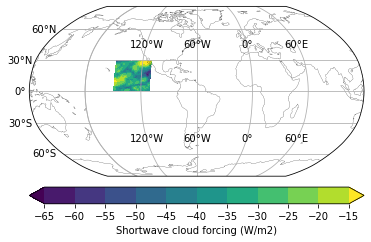

In [6]:
# for one region
# calculate area average of a field for region and ocean within region
# then plot after simple conversion to lat/lon grid

xi = np.linspace(0, 360, 721)  # to regrid to 1/2 degree
yi = np.linspace(-90, 90, 361)  # to regrid to 1/2 degree

mask = DS['NEP']
#mask = DS['lon'] < 999.# boolian array of True
print('mask',mask.values[0:10])

ind = np.where(~mask.values)
data = DS['SWCF'].squeeze()
wts = DS['area'].copy().squeeze()
wts[ind] = np.nan
data2d = data.copy().squeeze()
data2d[ind] = np.nan
zmax = data2d.max().values
zmin = data2d.min().values
print ('zmax, zmin', zmax, zmin)

# regional average, then ocean area average using data on cubed sphere
RA = (data2d*wts).squeeze().sum()/wts.sum()
VO = (data2d*OF*wts).squeeze().sum()/(OF*wts).sum()
print('reg avg, reg avg over ocean', RA.values, VO.values)

#data_regridded = griddata((lon, lat), data2d, (xi[None,:], yi[:,None]), method='linear')\
data_regridded = interp_to_latlon(data2d.values,lat,lon,yi,xi)
df = data_regridded.flatten()
dsub = df[np.isfinite(df)] # ignore NaN

dataproj=ccrs.PlateCarree()    # data is always assumed to be lat/lon
clon = (xleft+xright)/2.
#plotproj=ccrs.Orthographic(central_latitude=-0, central_longitude=clon)   # any projections should work 
plotproj=ccrs.Mollweide(central_longitude=clon)   # any projections should work 
plotproj=ccrs.Robinson(central_longitude=-60)   # any projections should work 
#plotproj=ccrs.Orthographic(central_latitude=-50)   # any projections should work 
ax = plt.axes(projection=plotproj)
ax.set_global()
ax.coastlines(linewidth=0.2)
clevs = findNiceContours(np.array([zmin,zmax]),nlevs=10)
print('clevs',clevs)
pl = ax.contourf(xi, yi, data_regridded, clevs, vmin=zmin, vmax=zmax,  extend='both', transform=ccrs.PlateCarree())
# Add colorbar to plot
cb = plt.colorbar(
    pl, orientation='horizontal',ticks=clevs,
    label='%s (%s)'%(data.long_name, data.units), pad=0.05
)
ax.gridlines(draw_labels=True, dms=True, x_inline=True, y_inline=False)
xx = plt.show

In [7]:

inCmd='ncdump -v time '+indir+' | grep "FRAC.*="'
outCmd = os.popen(inCmd).read()
print(inCmd)
print(outCmd)

ncdump -v time /home/phil/NetCDF_Files/F2010_PJR1.eam.h0.0001-01.nc | grep "FRAC.*="
		CLOUDFRAC_CLUBB:mdims = 1 ;
		CLOUDFRAC_CLUBB:units = "1" ;
		CLOUDFRAC_CLUBB:long_name = "Cloud Fraction" ;
		CLOUDFRAC_CLUBB:cell_methods = "time: mean" ;
		ICEFRAC:units = "1" ;
		ICEFRAC:long_name = "Fraction of sfc area covered by sea-ice" ;
		ICEFRAC:cell_methods = "time: mean" ;
		LANDFRAC:units = "1" ;
		LANDFRAC:long_name = "Fraction of sfc area covered by land" ;
		LANDFRAC:cell_methods = "time: mean" ;
		OCNFRAC:units = "1" ;
		OCNFRAC:long_name = "Fraction of sfc area covered by ocean" ;
		OCNFRAC:cell_methods = "time: mean" ;

